# Aula 13 &mdash; Regressão linear

Renato Vimieiro

rv2 {em} cin.ufpe.br

maio 2017

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.linear_model import LinearRegression

% matplotlib inline


## Introdução

Regressão linear é um método de aprendizado supervisionado que é muito simples, mas ainda assim muito eficiente e versátil na detecção e análise de padrões nos dados. O objetivo central do método de regressão linear é ajustar um modelo (um hiperplano) aos dados de forma a predizer o valor de um atributo quantitativo (variável dependente). Por exemplo, poderíamos tentar ajustar um modelo para predizer o valor do crédito a ser concedido a um cliente com base nos seus dados pessoais (salário, idade, tempo de serviço, empréstimos contraídos, dívidas, ...).

Embora o objetivo central seja a construção de um modelo de predição de valores da variável dependente, o modelo ainda pode fornecer informações sobre a influência das variáveis independentes sobre ela. Em outras palavras, podemos usar regressão linear para entender como certos atributos influenciam uns aos outros.

Essa aula é baseada no capítulo 3 do livro *An Introduction to Statistical Learning*, cujos detalhes estão nas referências da disciplina. Usaremos o mesmo exemplo base do livro. O exemplo consiste num conjunto de dados sobre o impacto de publicidade em três tipos de mídia (TV, jornal impresso, e rádio) nas vendas de um produto. A seguir carregamos o conjunto em um data frame:

In [2]:
ads = pd.read_csv("http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv",
                  usecols=[1,2,3,4])
print(ads.shape)
ads.head()

(200, 4)


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Antes de iniciarmos qualquer análise, devemos plotar os dados para avaliar se existe alguma relação entre o investimento em publicidade e o total de vendas.

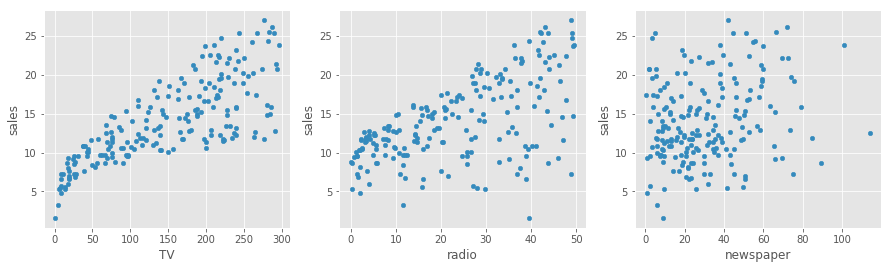

In [7]:
figs, axes = plt.subplots(1,3,figsize=(15,4))
ads[['TV','sales']].plot.scatter(x='TV',y='sales',ax=axes[0])
ads[['radio','sales']].plot.scatter(x='radio',y='sales',ax=axes[1])
ads[['newspaper','sales']].plot.scatter(x='newspaper',y='sales',ax=axes[2]);

Percebemos que existe uma certa relação entre o investimento em publicidade e o aumento de vendas. É verdade também que a relação talvez não seja exatamente linear, mas, em geral, supomos como tal para simplificar o modelo. Nesse ponto, surgem várias perguntas:

1. Em cada caso, qual a reta que melhor descreve os dados?
2. Quão forte é essa relação entre publicidade e vendas?
4. Qual a precisão do modelo e da influência dos meios nas vendas?
3. Das três mídias investidas, qual é a que mais contribui para o aumento de vendas?
5. Existe alguma interação entre as diferentes mídias? O efeito de cada uma delas é isolado ou elas se inter-influenciam?

## Regressão linear simples (método dos mínimos quadrados)

No caso mais simples de regressão linear, queremos determinar a equação de uma reta que melhor se ajusta ao conjunto de dados. Nossa suposição é que a relação entre a variável dependente e independente seja dada pela seguinte equação:

$$ Y = \beta_0 + \beta_1X $$.

A escolha de diferentes valores para os coeficientes $\beta_0$ e $\beta_1$ resulta em diferentes retas. Exemplos:

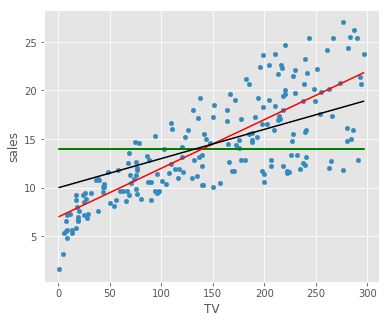

In [21]:
figs, ax = plt.subplots(1,1,figsize=(6,5))
ads[['TV','sales']].plot.scatter(x='TV',y='sales',ax=ax)
ax.plot(ads.TV,np.repeat(ads.sales.mean(),ads.shape[0]),color='green')
ax.plot(ads.TV.sort_values(inplace=False),ads.TV.map(lambda x: 0.05*x+7).iloc[ads.TV.argsort()],color='red')
ax.plot(ads.TV.sort_values(inplace=False),ads.TV.map(lambda x: 0.03*x+10).iloc[ads.TV.argsort()],color='black');

O problema é como encontrar os coeficientes que melhor se ajustam aos dados. Isso nos leva a refletir como definir o conceito de 'melhor se ajusta aos dados'. A definição mais comum leva em conta a minimização da soma dos quadrados dos erros (chamados de **resíduos**). Ou seja, deseja-se obter o mínimo para a função:

$$S(X) = \sum e_i^2 = \sum (y_i - \hat{\beta_0} - \hat{\beta_1}x_i)^2$$,
onde $\hat{\beta_0}$ e $\hat{\beta_1}$ são estimativas para os coeficientes.

A função atinge o mínimo quando sua derivada é zero. Assim, para calcular os coeficientes, derivamos a função, igualamos a zero e resolvemos o sistema resultante. O resultado é:

$$\hat{\beta_1} = \frac{\sum (x_i-\bar{x})(y_i-\bar{y})}{\sum (x_i-\bar{x})^2}$$

$$\hat{\beta_0} = \bar{y} -\hat{\beta_1}\bar{x}$$

Logo, podemos calcular os coeficientes para os dados do exemplo:

In [16]:
b1 = np.sum(ads.TV.map(lambda x: x-ads.TV.mean())*\
            ads.sales.map(lambda x: x-ads.sales.mean()))/\
np.sum(ads.TV.map(lambda x: (x-ads.TV.mean())**2))
b0 = ads.sales.mean()-b1*ads.TV.mean()
print('y = {:.3f} {:+.3f}x'.format(b0,b1))

y = 7.033 +0.048x


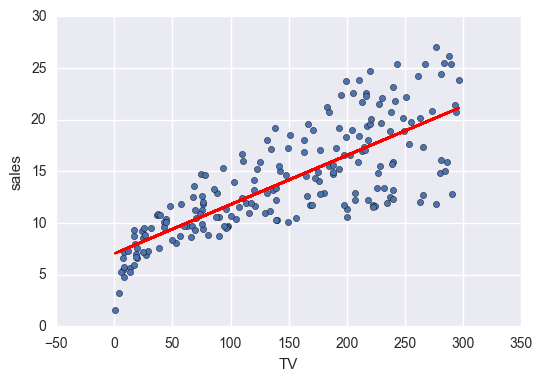

In [17]:
figs, ax = plt.subplots(1,1,figsize=(6,4))
ads[['TV','sales']].plot.scatter(x='TV',y='sales',ax=ax)
ax.plot(ads.TV,ads.TV.map(lambda x: b1*x+b0),color='red')


É importante ressaltar que, ainda que a relação entre as variáveis fosse realmente linear e soubéssemos os *verdadeiros* valores dos coeficientes $\beta_0$ e $\beta_1$, os valores encontrados pelo método dos mínimos quadrados seriam diferentes. Isso porque não consideramos erros que podem ser introduzidos aos dados por diversas vias (medições, representação numérica, ...). Assim, a equação mais fiel aos dados seria

$$ Y = \beta_0 + \beta_1X + \epsilon$$.

Para exemplificar, vamos considerar que a verdadeira relação entre uma variável dependente e independente seja dada pela equação $y = 5x + 3$. Agora, consideremos que os erros sigam uma distribuição normal com média zero e desvio padrão 10. Vamos gerar um conjunto de dados seguindo tais especificações e ver como o modelo é ajustado.

In [39]:
f = lambda x: 5*x+3
np.random.seed(111)
x = np.random.uniform(10,0,size=100)
e = np.random.normal(0,20,size=100)
yv = np.apply_along_axis(f,0,x)
y = yv+e

b1 = np.sum((x-np.mean(x))*(y-np.mean(y)))/np.sum((x-np.mean(x))**2)
b0 = np.mean(y)-b1*np.mean(x)
g = lambda x: b0+b1*x
yreg = np.apply_along_axis(g,0,x)

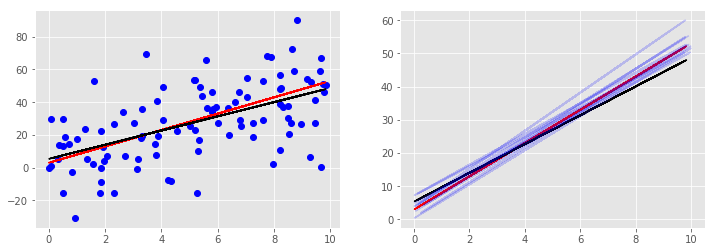

In [40]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(x,y,'o',color='blue')
axes[0].plot(x,yv,color='red')
axes[0].plot(x,yreg,color='black')

axes[1].plot(x,yv,color='red')
axes[1].plot(x,yreg,color='black')

for i in range(10):
    f = lambda x: 5*x+3
    x = np.random.uniform(10,0,size=100)
    e = np.random.normal(0,20,size=100)
    yv = np.apply_along_axis(f,0,x)
    y = yv+e

    b1 = np.sum((x-np.mean(x))*(y-np.mean(y)))/np.sum((x-np.mean(x))**2)
    b0 = np.mean(y)-b1*np.mean(x)
    g = lambda x: b0+b1*x
    yreg = np.apply_along_axis(g,0,x)
    axes[1].plot(x,yreg,color='blue',alpha=0.2)

Observamos que, dadas as premissas de que os erros seguem uma distribuição normal com média zero e desvio padrão $\sigma$, o valor médio entre as diversas predições para $Y$ se aproxima do valor real (dado pela equação da reta). Dessa forma, percebemos que não há um erro sistemático (viés) nas estimativas. Portanto, ainda que os coeficientes para um conjunto de dados específico não forneça a real relação entre as variáveis, se tivéssemos uma grande amostra de conjuntos de dados, a média dos coeficientes seria o valor exato deles.

#### Qualidade da estimativa dos coeficientes

Da mesma forma que usamos o erro padrão para avaliar quão distante a média da amostra está da média populacional, o erro padrão dos coeficientes revela quão distantes eles estão dos reais valores. Através das propriedades da variância e esperança, pode-se [demonstrar](http://qed.econ.queensu.ca/pub/faculty/abbott/econ351/351note04.pdf) que os erros padrão dos coeficientes são dados por

$$SE(\hat{\beta_0})^2 = \sigma^2\left[\frac{1}{n}+\frac{\bar{x}^2}{\sum (x_i-\bar{x})^2}\right]$$

$$SE(\hat{\beta_1})^2 = \frac{\sigma^2}{\sum (x_i-\bar{x})^2}$$,
onde $\sigma^2 = Var(\epsilon)$ e pode ser estimado por $S(x)/(n-2)$.

As estimativas de erro padrão podem ser usadas para definir os intervalos de confiança dos coeficientes. Por exemplo, os intervalos de confiança de 95% dos coeficientes são dados por

$$\left[\hat{\beta_0}-1.96~SE(\hat{\beta_0}),~~\hat{\beta_0}+1.96~SE(\hat{\beta_0})\right]$$
$$\left[\hat{\beta_1}-1.96~SE(\hat{\beta_1}),~~\hat{\beta_1}+1.96~SE(\hat{\beta_1})\right]$$

Assim, podemos calcular os intervalos de confiança dos coeficientes estimados para o problema da publicidade.

In [20]:
b1 = np.sum(ads.TV.map(lambda x: x-ads.TV.mean())*\
            ads.sales.map(lambda x: x-ads.sales.mean()))/\
np.sum(ads.TV.map(lambda x: (x-ads.TV.mean())**2))
b0 = ads.sales.mean()-b1*ads.TV.mean()

f = lambda x: b0+b1*x

RSE = np.sum((ads.sales.values-ads.TV.map(f))**2)/(ads.shape[0]-2)
TSS = np.sum(ads.TV.map(lambda x: (x-ads.TV.mean())**2))
SEb0 = np.sqrt(RSE*(1/ads.shape[0]+(ads.TV.mean()**2)/TSS))
SEb1 = np.sqrt(RSE/TSS)

print('b0 = [{:.3f}, {:.3f}]'.format(b0-1.96*SEb0,b0+1.96*SEb0))
print('b1 = [{:.3f}, {:.3f}]'.format(b1-1.96*SEb1,b1+1.96*SEb1))

b0 = [6.135, 7.930]
b1 = [0.042, 0.053]


Esses intervalos podem ser interpretados como:

- Na ausência de investimentos em publicidade, as vendas vão ficar entre 6 e 8 unidades
- O investimento de \$1000 em publicidade na TV resulta no aumento da venda de 42 a 53 unidades

## Quão forte é a relação entre publicidade e vendas

O erro padrão do coeficiente $\hat{\beta_1}$ também é útil para testar a força da relação entre o investimento em publicidade na TV e o aumento das vendas. Podemos testar a hipótese de que não existe relação entre o investimento em TV e aumento de vendas (i.e. $\beta_1=0$). Para isso avaliamos se o valor estimado é significativamente diferente de zero. Fazemos isso usando a estatística t

$$t = \frac{\hat{\beta_1} - 0}{SE(\hat{\beta_1})}$$

e avaliando a probabilidade de observar um valor tão extremo quanto $t$.

In [21]:
from scipy.stats import t

tB1 = b1/SEb1
print(tB1)
t.sf(tB1,ads.shape[0]-2) #sf = 1-cdf

17.6676256009


7.3369485009735888e-43

A probabilidade de observar um valor tão extremo quanto $t$ é quase zero como vimos acima. Esse valor, chamado de ***p-value***, nos informa a probabilidade do coeficiente computado ter ocorrido simplesmente por chance. Como essa probabilidade é bem pequena (em geral, os limiares usados para definir pequeno são 0.05 e 0.01), rejeitamos a hipótese de que o coeficiente real é zero. Em outras palavras, aceitamos que existe uma relação entre o investimento em TV e o aumento nas vendas.

## Qual a qualidade do modelo?

O teste de hipótese mostrou que, de fato, existe uma relação entre a variável dependente e a independente. O p-value calculado, no entanto, não mostra a precisão deste modelo. 

A qualidade do modelo é avaliada de duas formas: *erro padrão residual* e *coeficiente de determinação*.

O erro padrão residual (RSE) é uma estimativa do desvio padrão dos resíduos (erros) do modelo. Ele é definido por

$$RSE = \sqrt{\frac{S(x)}{n-2}} = \sqrt{\frac{\sum (y_i - \beta_0 - \beta_1x_i)^2}{n-2}}$$.

In [22]:
RSE = np.sqrt(np.sum((ads.sales.values-ads.TV.map(f))**2)/(ads.shape[0]-2))
RSE

3.2586563686504624

Intuitivamente, esse valor nos mostra que, em média, os valores de venda vão oscilar em 3.26 unidades do valor real.

O coeficiente de determinação, por outro lado, mostra a proporção da variância explicada pelo modelo. O coeficiente de determinação é calculado por

$$R^2 = \frac{TSS-RSS}{TSS}$$,
onde $TSS = \sum (y_i - \bar{y})^2$ e $RSS = S(x) = \sum (y_i - \beta_0 - \beta_1x_i)^2$

In [23]:
RSS = np.sum((ads.sales.values-ads.TV.map(f))**2)
TSS = np.sum((ads.sales.values-ads.sales.mean())**2)
R2 = (TSS-RSS)/TSS

print(TSS,RSS,R2)

5417.14875 2102.53058313 0.61187505085


O coeficiente de determinação varia entre 0 e 1. Valores próximos de zero indicam que o modelo não consegue explicar a variação dos dados, enquanto valores próximos de 1 indicam que a variação dos dados é totalmente explicada pelo modelo. 

Assim, percebemos que o modelo consegue explicar cerca de 61% da variação das vendas, ou seja, 2/3 do aumento das vendas pode ser explicada pelo investimento na publicidade em TV.

## Regressão linear em Python

Felizmente não precisamos usar todas equações derivadas acima para ajustar um modelo de regressão linear em Python. De fato, existem diversas formas de se fazê-lo, usando SciPy ou Scikit-Learn.

#### SciPy

In [24]:
from scipy.stats import linregress

X = ads.TV.values.copy()
y = ads.sales.values

model = linregress(X,y)
print('y = {:.3f} + {:.3f}x'.format(model.intercept,model.slope))
print('Stats')
print('r2 = {:.3f}, p-value={:.3f}'.format(model.rvalue**2,model.pvalue))

y = 7.033 + 0.048x
Stats
r2 = 0.612, p-value=0.000


#### sklearn

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, explained_variance_score

model = LinearRegression()
model.fit(X[:, np.newaxis],y)
print('y = {:.3f} + {:.3f}x'.format(model.intercept_,model.coef_[0]))
print('Stats')
print('r2 = {:.3f}'.format(r2_score(y,model.predict(X[:, np.newaxis]))))

y = 7.033 + 0.048x
Stats
r2 = 0.612


In [29]:
X[:, np.newaxis]

array([[ 230.1],
       [  44.5],
       [  17.2],
       [ 151.5],
       [ 180.8],
       [   8.7],
       [  57.5],
       [ 120.2],
       [   8.6],
       [ 199.8],
       [  66.1],
       [ 214.7],
       [  23.8],
       [  97.5],
       [ 204.1],
       [ 195.4],
       [  67.8],
       [ 281.4],
       [  69.2],
       [ 147.3],
       [ 218.4],
       [ 237.4],
       [  13.2],
       [ 228.3],
       [  62.3],
       [ 262.9],
       [ 142.9],
       [ 240.1],
       [ 248.8],
       [  70.6],
       [ 292.9],
       [ 112.9],
       [  97.2],
       [ 265.6],
       [  95.7],
       [ 290.7],
       [ 266.9],
       [  74.7],
       [  43.1],
       [ 228. ],
       [ 202.5],
       [ 177. ],
       [ 293.6],
       [ 206.9],
       [  25.1],
       [ 175.1],
       [  89.7],
       [ 239.9],
       [ 227.2],
       [  66.9],
       [ 199.8],
       [ 100.4],
       [ 216.4],
       [ 182.6],
       [ 262.7],
       [ 198.9],
       [   7.3],
       [ 136.2],
       [ 210.8